In [3]:
!pip install webcolors

  Using cached https://files.pythonhosted.org/packages/1d/44/c4902683be73beba20afd299705e11f0a753a01cc7f9d6a070841848605b/webcolors-1.8.1-py2.py3-none-any.whl


distributed 1.21.8 requires msgpack, which is not installed.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import webcolors
from PIL import Image
from pandas.core.frame import DataFrame
from typing import Dict, Tuple
from sklearn.svm import SVC

Wygenerujmy rozkład punktów podobny jak na powyższym obrazku. 

In [31]:
colors_dict = {
    '#ffffff': ('white', 0),
    '#ff0000': ('red', 1),
    '#ffbf00': ('orange', 2),
    '#ffff00': ('yellow', 3),
    '#00ff00': ('green', 4),
    '#00bfff': ('blue', 5),
    '#0000ff': ('dark blue', 6),
    '#551a8b': ('purple', 7),
    '#ffb6c1': ('pink', 8),
    '#000000': ('black', 9)
}

def closest_colour(requested_colour):
    min_colours = {}
    for key, name in colors_dict.items():
        r_c, g_c, b_c = webcolors.hex_to_rgb(key)
        rd = (r_c - requested_colour[0]) ** 2
        gd = (g_c - requested_colour[1]) ** 2
        bd = (b_c - requested_colour[2]) ** 2
        min_colours[(rd + gd + bd)] = name
    return min_colours[min(min_colours.keys())]

def get_colour_name(requested_colour):
    try:
        closest_name = webcolors.rgb_to_name(requested_colour)
    except ValueError:
        closest_name = closest_colour(requested_colour)
    return closest_name


In [75]:
def noise(point: float):
    return point + random.gauss(0.5, 0.2)

def write_data_to_csv(source_img: str, dest_path: str):
    """
    Save given image to csv-like format.
    Csv file contains 4 columns: x co-ordinate, y co-ordinate, color number, color name
    """
    image = Image.open(source_img)
    width, height = image.size
    with open(dest_path, 'w') as dest_file:
        for x in range(0, width):
            for y in range(0, height):
                color, color_num = closest_colour(image.getpixel((x,y)))
                if color != 'white':
                    dest_file.write(f'{noise(x)};{noise(y)};{color_num};{color}\n')

In [76]:
def divide_dataset(shuffled_dataset: np.ndarray) -> Tuple[np.ndarray]:
    """
    Return 4-elements tuple with X_train, y_train, X_test, y_test
    Function cast input - pandas DataFrame to  to numpy array, just for calucaltion simiplicity
    """
    if shuffled_dataset.shape[1] != 3:
        raise ValueError("Shuffled dataset must contains x,y and numeric value columns")

    train_size = int(0.7 * shuffled_dataset.shape[0])
    train, test = shuffled_dataset[:train_size, :], shuffled_dataset[train_size:, :]

    return train[:, 0:2], train[:, 2], test[:, 0:2], test[:, 2]

In [77]:
data = ('svm-data/svm.png', )
output_paths = ('svm-data/svm-dataset.csv', )

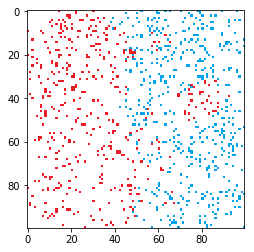

In [78]:
%matplotlib inline
def show_data(img_path):
    pil_im = Image.open(img_path, 'r')
    plt.imshow(np.asarray(pil_im))

def get_img_shape(img_path):  
    pil_im = Image.open(img_path, 'r')
    return pil_im.size

show_data(data[0])
org_shape = get_img_shape(data[0])

In [79]:
write_data_to_csv(data[0], output_paths[0])

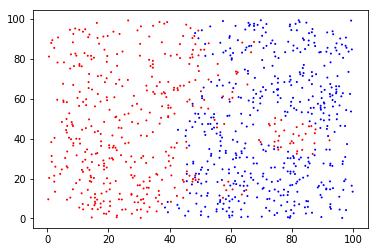

In [86]:
X = pd.read_csv(output_paths[0], sep=';', names=['x', 'y', 'color_num', 'color'])
colors = X.iloc[:, 3]
X = X.iloc[:, :3]
X = np.array(X, dtype=np.float32)

plt.scatter(X[:, 0], X[:, 1], s=1, c=colors)
plt.show()

Dla takiego rozkładu zbadajmy jak będą się zachowywały w zależności od wybranego współczynnika C (rozumianego jako - współczynnik sterujący równowagą między zwiększaniem marginesu, a zmniejszaniem ilości punktów po złej stronie granicy) następujące wartości (do przetestowania rozsądny zakres i ilość współczynników C - tak aby pokazać trend na wykresie):
 * jaka jest szerokość marginesu;
 * jaki % punktów znalazł się po "niewłaściwej" stronie płaszczyzny dzielącej klasy.

In [87]:
np.random.shuffle(X)
X_train, y_train, X_test, y_test = divide_dataset(X[:, :3])

In [88]:
n = 10000
X_random = np.random.rand(n, 2) * org_shape[0]

In [119]:
Cs = [0.00001, 0.0001, 0.001, 0.01, 0.1 , 1, 10, 100]
x_s = np.log10(Cs)

In [107]:
def svn_scores(kernel: str, Cs: list,  **kwargs):
    accs_test = []
    widths = []
    accs_trains = []

    for c in Cs:
        svm = SVC(C=c, kernel=kernel, **kwargs)
        svm.fit(X_train, y_train)
        
        acc_train = svm.score(X_train, y_train)
        acc_test = svm.score(X_test, y_test)
        dec = svm.decision_function(X_random)
        width = np.sum(np.abs(dec) < 1) / len(X_random)
        
        accs_trains.append(acc_train)
        accs_test.append(acc_test)
        widths.append(width)
    
    return accs_trains, accs_test, widths

In [141]:
def plot_results_accs(acc_trains: list, acc_test: list, x: list):
    plt.figure(figsize=(10, 10))
    plt.title("SWM accuracy on train and test data")
    plt.xlabel("C value. log_{10}(C)")
    plt.ylabel("accuracy")
    plt.plot(x, acc_trains, label="train_data")
    plt.plot(x, acc_test, label="test_data")
    plt.legend()

def plot_results_widths(widths: list, x: list): 
    plt.figure(figsize=(10, 10))
    plt.title("Margin width")
    plt.xlabel("C value. log_{10}(C)")
    plt.ylabel("margin width")
    plt.plot(x, widths)

### Standard SVM

In [109]:
accs_trains, accs_test, widths = svn_scores(kernel='linear', Cs=Cs)

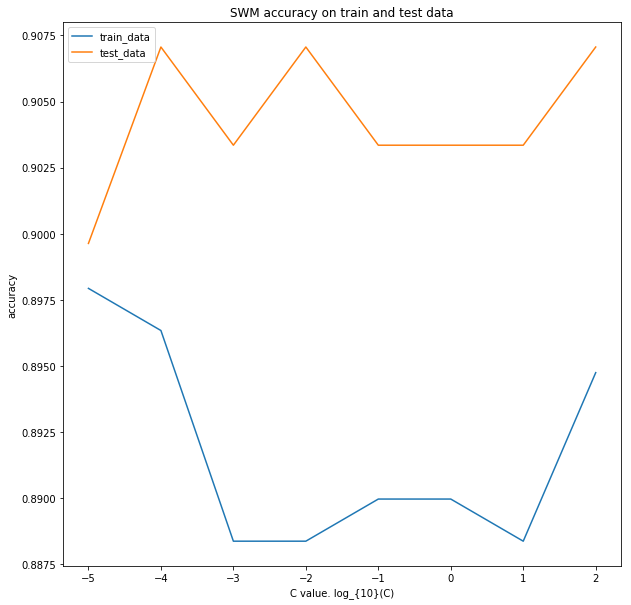

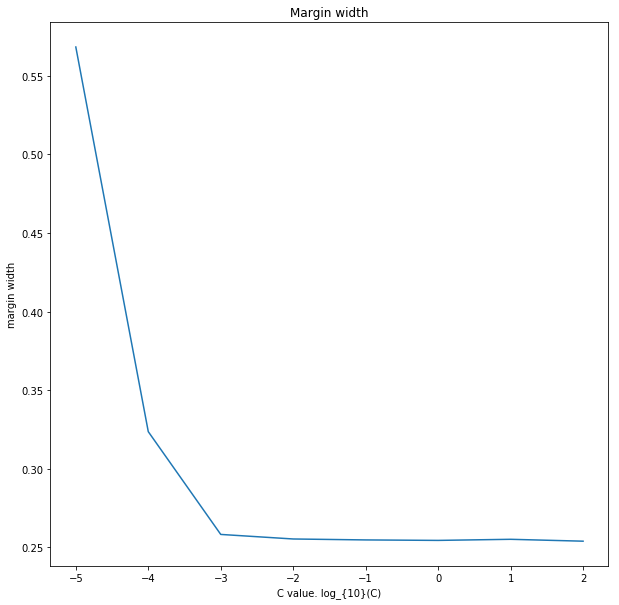

In [142]:
plot_results_accs(accs_trains, accs_test, x_s)
plot_results_widths(widths, x_s)

### SVM with polynomial karnel

In [143]:
accs_trains, accs_test, widths = svn_scores(kernel='poly', Cs=Cs, gamma='scale', coef0=3)

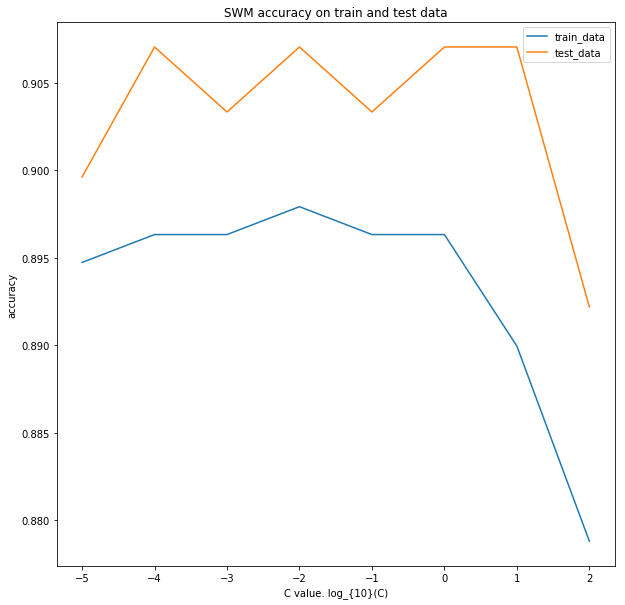

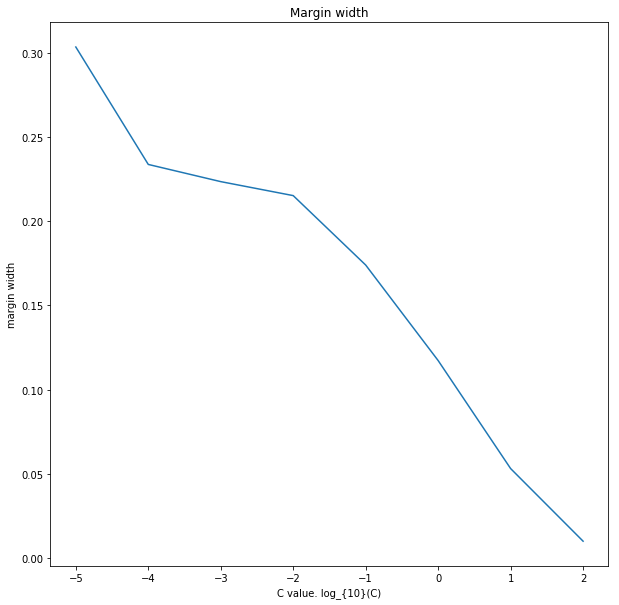

In [144]:
plot_results_accs(accs_trains, accs_test, x_s)
plot_results_widths(widths, x_s)

### SVM with RBF karnel

##### gamma = 0.0001

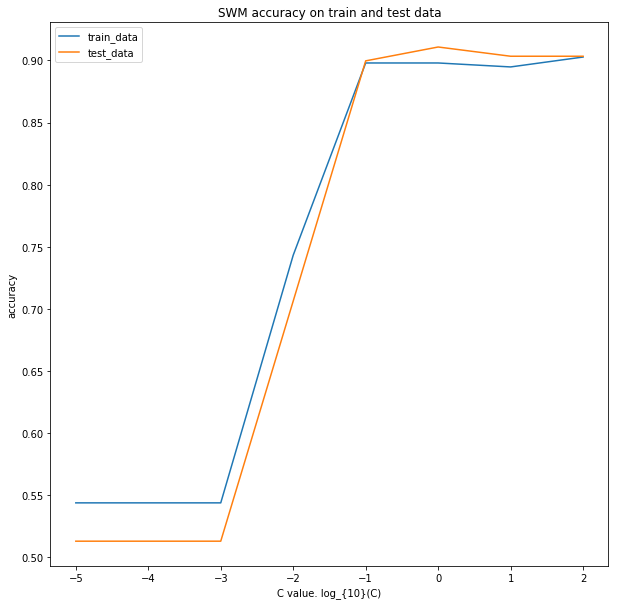

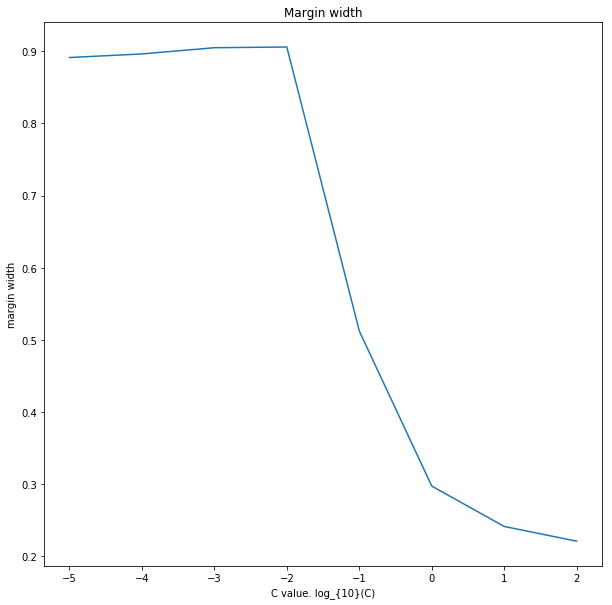

In [152]:
gamma = 0.0001
accs_trains, accs_test, widths = svn_scores(kernel="rbf", Cs=Cs, gamma=gamma)
plot_results_accs(accs_trains, accs_test, x_s)
plot_results_widths(widths, x_s)

##### gamma = 0.01

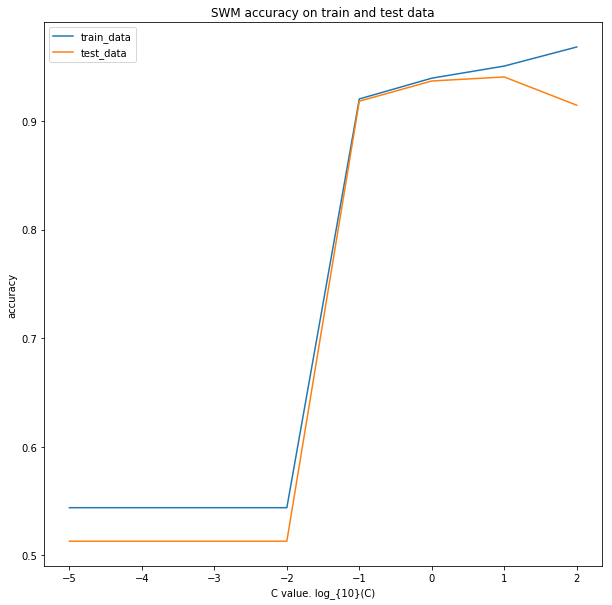

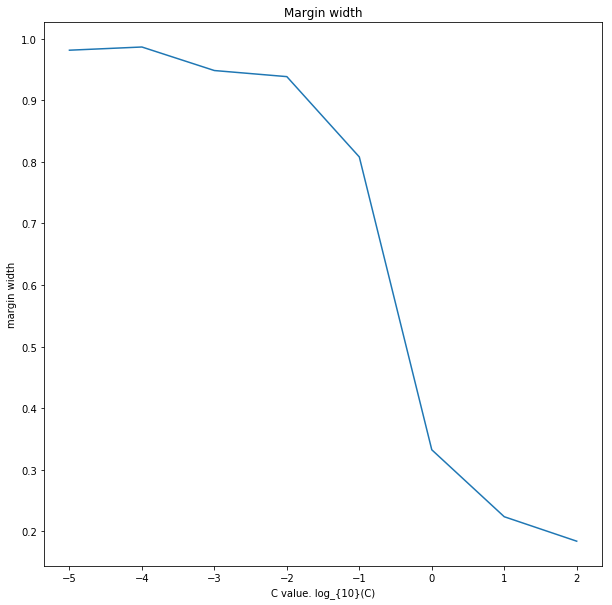

In [153]:
gamma = 0.01
accs_trains, accs_test, widths = svn_scores(kernel="rbf", Cs=Cs, gamma=gamma)
plot_results_accs(accs_trains, accs_test, x_s)
plot_results_widths(widths, x_s)

##### gamma = 1

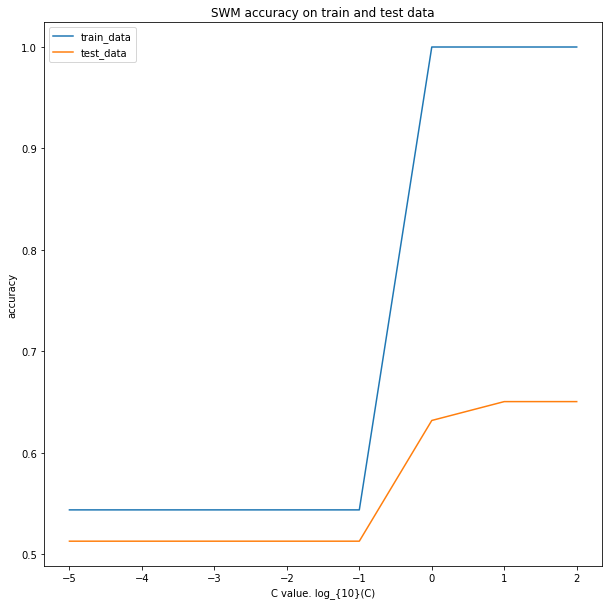

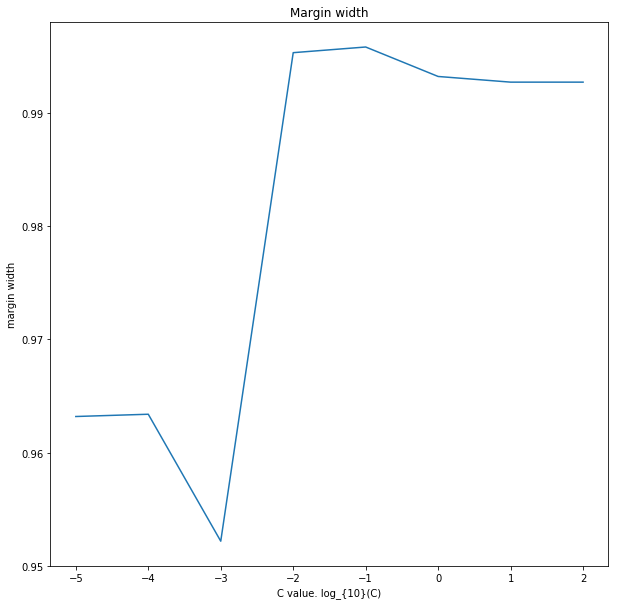

In [154]:
gamma = 1
accs_trains, accs_test, widths = svn_scores(kernel="rbf", Cs=Cs, gamma=gamma)
plot_results_accs(accs_trains, accs_test, x_s)
plot_results_widths(widths, x_s)

##### gamma = 10

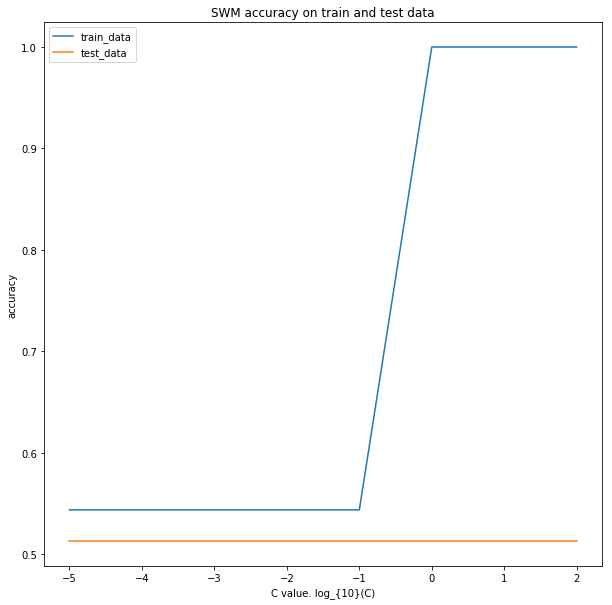

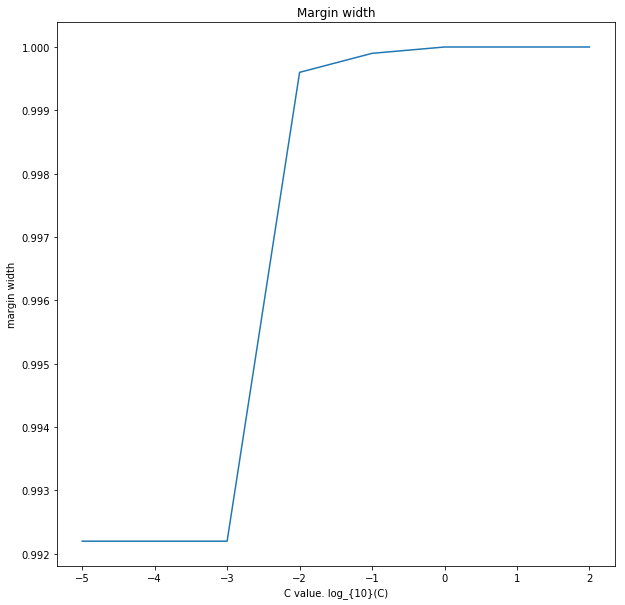

In [157]:
gamma = 10
accs_trains, accs_test, widths = svn_scores(kernel="rbf", Cs=Cs, gamma=gamma)
plot_results_accs(accs_trains, accs_test, x_s)
plot_results_widths(widths, x_s)

Na koniec zwizualizujmy też efekty działania poprzez odpowiednie pomalowanie płaszczyzny (tak jak robiliśmy to przy metodzie k-NN). Z jednym wyjątkiem - tym razem niech odcień danego piksela zależy od odległości od płaszczyzny podziału (bliskie punkty = sporne = jasne, dalekie punkty = jednoznaczne = ciemne).

In [163]:
def visualize_svm(svm:SVC):
    svm.fit(X_train, y_train)
    decisions = svm.decision_function(X_random)
    for x_s, d in zip(X_random, decisions):
        a = min(np.abs(d), 1)
        plt.scatter([x_s[0]], [x_s[1]], c=["g" if d > 0 else "b"], alpha=a)
    plt.scatter(X_train[:, 0], X_train[:, 1], 
                c=y_train
               )
    plt.title(f"classification of {svm}")
    plt.show()

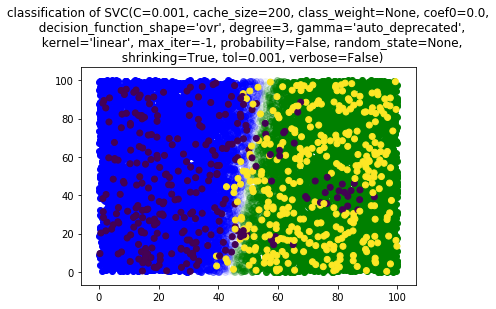

In [164]:
for svm in [
    SVC(kernel="linear", C=10e-4),
#     SVC(kernel="linear", C=1),
#     SVC(kernel="linear", C=100),

]:
    visualize_svm(svm)